In [1]:
## This is an example snippet!
# To create your own, add a new snippet block to the
# snippets.json file in your jupyter nbextensions directory:
# /nbextensions/snippets/snippets.json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

%matplotlib inline
# from warnings import filterwarnings
# filterwarnings('ignore')

In [2]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

import tensorflow as tf
from tensorflow.contrib import graph_editor as ge

from torchvision.transforms import CenterCrop

from IPython.display import clear_output


In [3]:
CHECKPOINT = '../results/q=10/log/celebA_64_64'

In [4]:
# 019948.jpg
# 160116.jpg
# 190604.jpg
# 152198.jpg

In [89]:
!ls

002094.jpg  044586.jpg	072355.jpg  166310.jpg	Untitled.ipynb
006828.jpg  053880.jpg	152198.jpg  173204.jpg	asd.png
019948.jpg  065705.jpg	159618.jpg  182370.jpg	gif.gif
023156.jpg  067131.jpg	160116.jpg  187065.jpg	img.png
031488.jpg  067534.jpg	163809.jpg  190604.jpg	w_optimization.ipynb


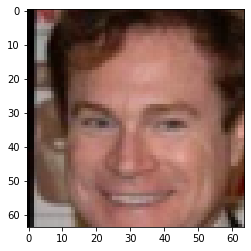

In [120]:
from PIL import Image

lemp = Image.open('166310.jpg')
i = 20
crop_size = min(lemp.size)
lemp = np.array(CenterCrop((128, 128))(lemp).resize((64, 64)))
plt.imshow(lemp)

In [6]:
sys.path.insert(0, '/Users/starlight/Desktop/Neuromation/hologan/')

In [7]:
from modules.tools.rotation_utils import generate_random_rotation_translation
from config import config as cfg

## Class

In [115]:
from uuid import uuid4

class Rotator:
    IDENTITY_VIEW = generate_random_rotation_translation(
        1,
        90, 91,
        270, 271,
        with_translation=False,
        with_scale=False
    )
    
    def __init__(self, checkpoint_path):
        self.sess = tf.Session()
        
        emb_graph = self._load_pb(str(cfg.emb_tf_model))
        new_saver = tf.train.import_meta_graph(tf.train.latest_checkpoint(checkpoint_path) + '.meta')
        new_saver.restore(self.sess, tf.train.latest_checkpoint(checkpoint_path))
        output = self.sess.graph.get_tensor_by_name('generator/output:0')
        view_in = self.sess.graph.get_tensor_by_name('view_in:0')
        z = self.sess.graph.get_tensor_by_name('z:0')
        
        z_name = str(uuid4())
        self.z_ = tf.get_variable(z_name, trainable=True,
                          initializer=lambda: np.random.uniform(-1., 1., (1, z.shape[1])).astype(np.float32))
        
        with self.sess.graph.as_default():
            self.output_, self.view_in_ = ge.graph_replace(
                [output, view_in], {z: self.sess.graph.get_tensor_by_name(f'{z_name}:0')})
            
        self.img_ = tf.placeholder(tf.float32, self.output_.shape, 'img_')
        self.apply_z_loss = tf.placeholder(tf.float32, [])
        self.mse = tf.reduce_mean(tf.square(self.output_ - self.img_)) + \
                   1 * tf.reduce_mean(tf.square(1 + tf.nn.relu(tf.abs(self.z_) - 0.9)))
        
        self.optimizer = tf.train.AdamOptimizer(1e-1)
        self.step = self.optimizer.minimize(self.mse, var_list=[self.z_])
        
    
    def approx(self, image, n_iter=5000):
        self.sess.run(self.z_.initializer)
        self.sess.run(tf.initialize_variables([self.z_, *self.optimizer.variables()]))
        
        self._last_image = image
        init = self._denormalize(self.sess.run(self.output_, feed_dict={self.view_in_: self.IDENTITY_VIEW})[0])
        image = self._normalize(np.array(image)[None, :, :, :])
        
        losses = []
        for i in range(n_iter):
            apply_z_loss = 1 if i < 3000 else 0
            _, loss = self.sess.run(
                [self.step, self.mse],
                feed_dict={self.img_: image, self.view_in_: self.IDENTITY_VIEW, self.apply_z_loss: apply_z_loss}
            )
            
            losses.append(loss)
#             if i % 500 == 1:
#                 clear_output()
        print(loss)
        plt.plot(losses)
        plt.show()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(init)
        plt.subplot(1, 3, 2)
        plt.imshow(self._denormalize(image[0]))
        plt.subplot(1, 3, 3)
        plt.imshow(self._denormalize(self.sess.run(
            self.output_, feed_dict={self.view_in_: self.IDENTITY_VIEW})[0]))
        plt.show()
                
        return np.mean(losses[-10:])
                
                
    def save_gif(self):
        images = []
        for i in [*np.linspace(-60, 60, 50), *reversed(np.linspace(-60, 60, 50))]:
            img = self.sess.run(self.output_, feed_dict={self.view_in_: generate_random_rotation_translation(
                1,
                90, 91,
                270 + i, 271 + i,
                0, 0,
                0, 0,
                0, 0,
                with_translation=False,
                with_scale=False
            )})[0]
            img = self._denormalize(img)
            images.append(Image.fromarray((img * 255).astype(np.uint8)))

        img, *imgs = images
        img.save('gif.gif', format='GIF', append_images=imgs,
                 save_all=True, duration=100, loop=1)
        
        
    def save_png(self, name):
        images = []
        for i in np.linspace(-60, 60, 7):
            img = self.sess.run(self.output_, feed_dict={self.view_in_: generate_random_rotation_translation(
                1,
                90, 91,
                270 + i, 271 + i,
                0, 0,
                0, 0,
                0, 0,
                with_translation=False,
                with_scale=False
            )})[0]
            img = self._denormalize(img) * 255
            images.append(img)

        images = np.concatenate(images, 1).astype(np.uint8)
        images = np.concatenate([rotator._last_image, images], axis=1)
        images = Image.fromarray(images)
        images.save(name)
        
        return images
       
    
    @staticmethod
    def _normalize(image):
        if (image > 1).any():
            image = image / image.max()
        assert image.min() >= 0 and image.max() <= 1
        return image * 2 - 1
    
    
    @staticmethod
    def _denormalize(image):
        return (image + 1) / 2
        
    
    @staticmethod
    def _load_pb(path_to_pb):
        with tf.gfile.GFile(path_to_pb, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
        with tf.Graph().as_default() as graph:
            tf.import_graph_def(graph_def, name='')
            return graph

INFO:tensorflow:Restoring parameters from /project/config/../results/q=10/log/celebA_64_64/HoloGAN.model-218001
1.0421721


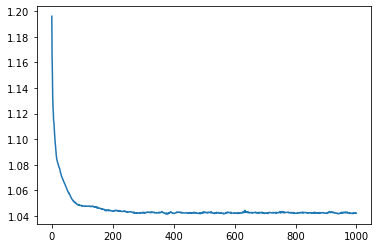

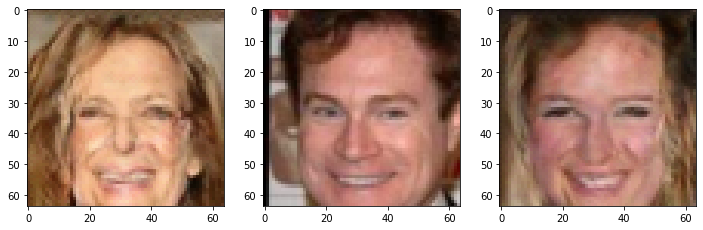

In [121]:
baseline = 2
for i in range(1):
    rotator = Rotator(CHECKPOINT)
    loss = rotator.approx(lemp, n_iter=1000)
    if loss < baseline:
        baseline = loss
        rotator.save_gif()

In [109]:
final_images.append(rotator.save_png('asd.png'))

In [110]:
fi = list(map(np.array, final_images))

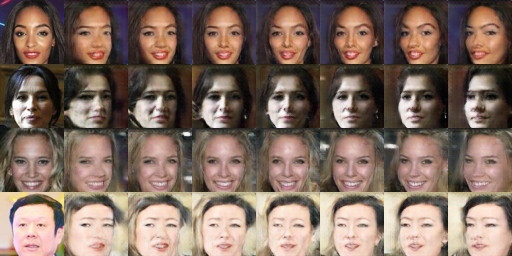

In [112]:
Image.fromarray(np.concatenate(fi, axis=0))

In [ ]:
rotator = Rotator(CHECKPOINT)

In [ ]:
rotator.approx(lemp)

In [148]:
rotator.save_gif()

In [72]:
final_images = []

In [103]:
rotator.z_.value().eval(session=rotator.sess).max()

1.2826204

In [104]:
rotator.z_.value().eval(session=rotator.sess).min()

-1.6018306

## Optimizing

In [48]:
emb_graph = load_pb(str(cfg.emb_tf_model))
sess = tf.Session()
new_saver = tf.train.import_meta_graph(CHECKPOINT + '/HoloGAN.model-218001.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(CHECKPOINT))
output = sess.graph.get_tensor_by_name('generator/output:0')
view_in = sess.graph.get_tensor_by_name('view_in:0')
z = sess.graph.get_tensor_by_name('z:0')
t = sess.graph.get_operation_by_name('generator/Const_2').outputs[0]

NameError: name 'load_pb' is not defined

In [19]:
z_ = tf.get_variable('z__', trainable=True, initializer=lambda: np.random.uniform(-1., 1., (1, z.shape[1])).astype(np.float32))

In [20]:
with sess.graph.as_default():
    output_, view_in_ = ge.graph_replace([output, view_in], {z: sess.graph.get_tensor_by_name('z__:0')})

Instructions for updating:
Please use tensorflow.python.ops.op_selector.get_backward_walk_ops.
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


In [21]:
img_ = tf.placeholder(tf.float32, output_.shape, 'img_')

In [22]:
def count_emb_loss(output, img):
    with sess.graph.as_default():
        output = tf.transpose(tf.image.resize_images(output, (112, 112)), [0, 3, 1, 2])
        out_emb = tf.import_graph_def(emb_graph.as_graph_def(),
                                      return_elements=['emb_output:0'],
                                      input_map={'emb_input:0': output})[0]
        img = tf.transpose(tf.image.resize_images(img, (112, 112)), [0, 3, 1, 2])
        img_emb = tf.import_graph_def(emb_graph.as_graph_def(),
                                      return_elements=['emb_output:0'],
                                      input_map={'emb_input:0': img})[0]
    return tf.reduce_mean(tf.square(out_emb - img_emb))

In [23]:
# mse =  #+ tf.reduce_mean(tf.square(tf.nn.relu(tf.abs(z_) - 1)))

In [32]:
mse =  tf.reduce_mean(tf.square(output_ - img_)) #+ tf.reduce_mean(tf.square(tf.nn.relu(tf.abs(z_) - 1)))

In [ ]:
# 10 * count_emb_loss(output_, img_)

In [33]:
optimizer = tf.train.AdamOptimizer(1e-1)
step = optimizer.minimize(mse, var_list=[z_])

In [34]:
sess.run(z_.initializer)
sess.run(tf.initialize_variables([z_, *optimizer.variables()]))

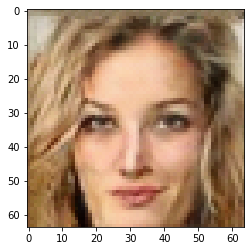

In [35]:
plt.imshow(list(map(transform_pix, sess.run(output_, feed_dict={view_in_: [SAMPLE_VIEW[0]]})))[0])

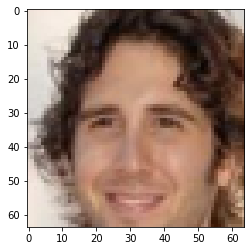

In [36]:
plt.imshow(lemp[0])

In [37]:
losses = []

In [38]:
for i in range(5000):
    _, loss = sess.run([step, mse], feed_dict={img_: lemp / 127.5 - 1, view_in_: generate_random_rotation_translation(
        1,
        90, 91,
        270, 271,
        with_translation=False,
        with_scale=False
    )})
    losses.append(loss)
    if i % 500 == 1:
        print(loss)
        plt.plot(losses)
        plt.show()
        plt.imshow(list(map(transform_pix, sess.run(output_, feed_dict={view_in_: [SAMPLE_VIEW[0]]})))[0])
        plt.show()
        clear_output(True)

KeyboardInterrupt: 

In [39]:
images = []
for i in [*np.linspace(-60, 60, 50), *reversed(np.linspace(-60, 60, 50))]:
    img = (sess.run(output_, feed_dict={img_: lemp / 127.5 - 1, view_in_: generate_random_rotation_translation(
        1,
        90, 91,
        270 + i, 271 + i,
        0, 0,
        0, 0,
        0, 0,
        with_translation=False,
        with_scale=False
    )})[0] + 1) / 2
    images.append(Image.fromarray((img * 255).astype(np.uint8)))

In [40]:
img, *imgs = images
img.save('gif.gif', format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=1)

## Optimizing 2

In [14]:
sess = tf.Session()
new_saver = tf.train.import_meta_graph(CHECKPOINT + '/HoloGAN.model-218001.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(CHECKPOINT))
output = sess.graph.get_tensor_by_name('generator/output:0')
view_in = sess.graph.get_tensor_by_name('view_in:0')
z = sess.graph.get_tensor_by_name('z:0')

INFO:tensorflow:Restoring parameters from ../results/q=10/log/celebA_64_64/HoloGAN.model-218001


In [46]:
to_replace = [
    op.outputs[0].consumers()[0].outputs[0].consumers()[0].outputs[0]
    for op in z.consumers() if 'MatMul' in op.name and 'grad' not in op.name
]

replaced = []

for i, tensor in enumerate(to_replace):
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        replaced.append(tf.get_variable(
            f'z_{i}',
            trainable=True,
            initializer=lambda: np.random.uniform(0, 1., (1, tensor.shape[1])).astype(np.float32)
        ))

In [47]:
with sess.graph.as_default():
    output_, view_in_ = ge.graph_replace(
        [output, view_in],
        dict(zip(to_replace, [sess.graph.get_tensor_by_name(var.name) for var in replaced])))

In [48]:
img_ = tf.placeholder(tf.float32, output_.shape, 'img_')

In [97]:
mse = tf.reduce_mean(tf.abs(output_ - img_)) #+ tf.reduce_mean(tf.square(tf.nn.relu(tf.abs(z_) - 1)))

In [104]:
optimizer = tf.train.AdamOptimizer(1e-2)
step = optimizer.minimize(mse, var_list=replaced)

In [105]:
sess.run(tf.initialize_variables([*replaced, *optimizer.variables()]))

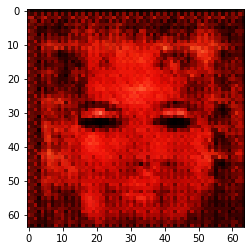

In [106]:
plt.imshow(list(map(transform_pix, sess.run(output_, feed_dict={z: np.zeros([1, 128]), view_in_: [SAMPLE_VIEW[0]]})))[0])

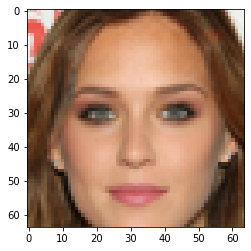

In [107]:
plt.imshow(lemp[0])

In [108]:
from IPython.display import clear_output

In [109]:
losses = []
for i in range(1000):
    _, loss = sess.run([step, mse], feed_dict={z: np.zeros([1, 128]), img_: lemp / 127.5 - 1, view_in_: generate_random_rotation_translation(
        1,
        90, 91,
        270, 271,
        0, 0,
        0, 0,
        0, 0,
        with_translation=False,
        with_scale=False
    )})
    losses.append(loss)
    if i % 50 == 1:
        plt.plot(losses)
        plt.show()
        clear_output(True)

KeyboardInterrupt: 

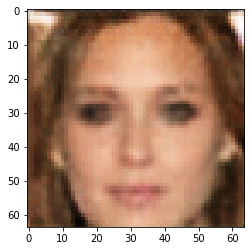

In [110]:
plt.imshow(list(map(transform_pix, sess.run(output_, feed_dict={z: np.zeros([1, 128]), view_in_: [SAMPLE_VIEW[0]]})))[0])

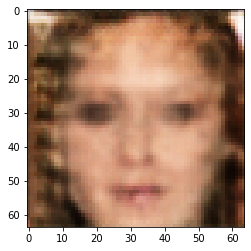

In [115]:
plt.imshow((sess.run(output_, feed_dict={z: np.zeros([1, 128]), img_: lemp / 127.5 - 1, view_in_: generate_random_rotation_translation(
        1,
        90, 91,
        270, 271,
        0, 0,
        0, 0,
        0, 0,
        with_translation=False,
        with_scale=False
    )})[0] + 1) / 2)